<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">


# Web Scraping for Indeed.com and Predicting Salaries

In this project, we will practice two major skills: collecting data by scraping a website and then building a binary predictor with Logistic Regression.

We are going to collect salary information on data science jobs in a variety of markets. Then using the location, title and summary of the job we will attempt to predict the salary of the job. For job posting sites, this would be extraordinarily useful. While most listings DO NOT come with salary information (as you will see in this exercise), being able to extrapolate or predict the expected salaries from other listings can help guide negotiations.

Normally, we could use regression for this task; however, we will convert this problem into classification and use Logistic Regression or any other suitable classifier.

- Question: Why would we want this to be a classification problem?
- Answer: While more precision may be better, there is a fair amount of natural variance in job salaries - predicting a range may be useful.

Therefore, the first part of the assignment will be focused on scraping Indeed.com. In the second, we'll focus on using listings with salary information to build a model and predict additional salaries.

### Scraping job listings from Indeed.com

We will be scraping job listings from Indeed.com using BeautifulSoup. Luckily, Indeed.com is a simple text page where we can easily find relevant entries.

First, look at the source of an Indeed.com page: (http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10").

Notice, each job listing is underneath a `div` tag with a class name of `result`. We can use BeautifulSoup to extract those. 

#### Setup a request (using `requests`) to the URL below. Use BeautifulSoup to parse the page and extract all results (HINT: Look for div tags with class name result)

The URL here has many query parameters:

- `q` for the job search
- This is followed by "+20,000" to return results with salaries (or expected salaries >$20,000)
- `l` for a location 
- `start` for what result number to start on

In [78]:
URL = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

In [79]:
import requests, json
import bs4
from bs4 import BeautifulSoup
import pandas as pd
import json
from tqdm import tqdm

In [80]:
# We are going to make a get call to the end point "https://foursquare.com/user/USER_ID":

r_ = requests.get(URL)

r_

<Response [200]>

In [81]:
# This is the server's response:

r_.text

'<!DOCTYPE html>\n<html lang="en">\n<head>\n<meta http-equiv="content-type" content="text/html;charset=UTF-8">\n<script type="text/javascript" src="/s/c524fdb/en_US.js"></script>\n<link href="/s/ecdfb5e/jobsearch_all.css" rel="stylesheet" type="text/css">\n<link rel="alternate" type="application/rss+xml" title="Data Scientist $20,000 Jobs, Employment in New York State" href="http://rss.indeed.com/rss?q=data+scientist+%2420%2C000&l=New+York">\n<link rel="alternate" media="only screen and (max-width: 640px)" href="/m/jobs?q=data+scientist+%2420%2C000&l=New+York">\n<link rel="alternate" media="handheld" href="/m/jobs?q=data+scientist+%2420%2C000&l=New+York">\n<script type="text/javascript">\n    \n    if (typeof window[\'closureReadyCallbacks\'] == \'undefined\') {\n        window[\'closureReadyCallbacks\'] = [];\n    }\n\n    function call_when_jsall_loaded(cb) {\n        if (window[\'closureReady\']) {\n            cb();\n        } else {\n            window[\'closureReadyCallbacks\'].p

In [82]:
html = r_.text

In [83]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(html, 'html.parser')

In [84]:
soup.title

<title>Data Scientist $20,000 Jobs, Employment in New York State | Indeed.com</title>

In [85]:
soup

<!DOCTYPE html>

<html lang="en">
<head>
<meta content="text/html;charset=utf-8" http-equiv="content-type"/>
<script src="/s/c524fdb/en_US.js" type="text/javascript"></script>
<link href="/s/ecdfb5e/jobsearch_all.css" rel="stylesheet" type="text/css"/>
<link href="http://rss.indeed.com/rss?q=data+scientist+%2420%2C000&amp;l=New+York" rel="alternate" title="Data Scientist $20,000 Jobs, Employment in New York State" type="application/rss+xml"/>
<link href="/m/jobs?q=data+scientist+%2420%2C000&amp;l=New+York" media="only screen and (max-width: 640px)" rel="alternate"/>
<link href="/m/jobs?q=data+scientist+%2420%2C000&amp;l=New+York" media="handheld" rel="alternate"/>
<script type="text/javascript">
    
    if (typeof window['closureReadyCallbacks'] == 'undefined') {
        window['closureReadyCallbacks'] = [];
    }

    function call_when_jsall_loaded(cb) {
        if (window['closureReady']) {
            cb();
        } else {
            window['closureReadyCallbacks'].push(cb);
   

In [86]:
# Job titles

for clickcard in soup.find_all('div', class_=' row result'):
    print(clickcard.find('a', class_='turnstileLink').text)
    

Quantitative Researcher in Machine Learning
HBO Director, Data Science
Analyst - Healthcare Analytics & Delivery, McKinsey New Vent...
Machine Learning
Quantitative Analyst
Machine Learning Engineer – Personalization & Recommendation...
Machine Learning Engineer
NLP/Machine Learning Engineer
Machine Learning Engineer


In [87]:
# Locations

for clickcard in soup.find_all('div', class_=' row result'):
    print(clickcard.find('span', class_='location').text)

New York, NY
New York, NY
New York, NY 10022 (Midtown area)
New York, NY
New York, NY
New York, NY 10011 (Chelsea area)
New York, NY 10013 (Tribeca area)
New York, NY
New York, NY


In [88]:
# Company

for clickcard in soup.find_all('div', class_=' row result'):
    print(clickcard.find('span', class_='company').text)



    Two Sigma Investments, LLC.


    HBO


    McKinsey & Company


    Twitter


    State Street


    Spotify

    Temboo


    Kasisto


    Memorial Sloan Kettering


Let's look at one result more closely. A single `result` looks like

```
<div class=" row result" data-jk="2480d203f7e97210" data-tn-component="organicJob" id="p_2480d203f7e97210" itemscope="" itemtype="http://schema.org/JobPosting">
<h2 class="jobtitle" id="jl_2480d203f7e97210">
<a class="turnstileLink" data-tn-element="jobTitle" onmousedown="return rclk(this,jobmap[0],1);" rel="nofollow" target="_blank" title="AVP/Quantitative Analyst">AVP/Quantitative Analyst</a>
</h2>
<span class="company" itemprop="hiringOrganization" itemtype="http://schema.org/Organization">
<span itemprop="name">
<a href="/cmp/Alliancebernstein?from=SERP&amp;campaignid=serp-linkcompanyname&amp;fromjk=2480d203f7e97210&amp;jcid=b374f2a780e04789" target="_blank">
    AllianceBernstein</a></span>
</span>
<tr>
<td class="snip">
<nobr>$117,500 - $127,500 a year</nobr>
<div>
<span class="summary" itemprop="description">
C onduct quantitative and statistical research as well as portfolio management for various investment portfolios. Collaborate with Quantitative Analysts and</span>
</div>
</div>
</td>
</tr>
</table>
</div>
```

While this has some more verbose elements removed, we can see that there is some structure to the above:
- The salary is available in a `nobr` element inside of a `td` element with `class='snip'`.
- The title of a job is in a link with class set to `jobtitle` and a `data-tn-element='jobTitle'`.  
- The location is set in a `span` with `class='location'`. 
- The company is set in a `span` with `class='company'`. 

### Write 4 functions to extract each item: location, company, job, and salary.

Example: 
```python
def extract_location_from_result(result):
    return result.find ...
```


- **Make sure these functions are robust and can handle cases where the data/field may not be available.**
    - Remember to check if a field is empty or `None` for attempting to call methods on it.
    - Remember to use `try/except` if you anticipate errors.
- **Test** the functions on the results above and simple examples.

In [89]:
def extract_location_from_result(clickcard):
    try:
        location = clickcard.find('span', class_='location').text
    except: 
        location = np.nan
    return location


In [90]:
def extract_company_from_result(clickcard):
    try:
        company = clickcard.find('span', class_='company').text
        company = company.strip('\n').strip()
    except: 
        company = np.nan
    return company


In [91]:
def extract_salary_from_result(clickcard):
    try:
        sal = clickcard.find('span', attrs={'class':'no-wrap'}).text
        sal = sal.strip('\n').strip()
        return sal
    except:
        return np.nan

In [92]:
def extract_title_from_result(clickcard):
    return clickcard.find('a', attrs={'class':'turnstileLink'})['title']


In [93]:
for result in soup.find_all('div', class_=' row result'):
    print(extract_company_from_result(result))

Two Sigma Investments, LLC.
HBO
McKinsey & Company
Twitter
State Street
Spotify
Temboo
Kasisto
Memorial Sloan Kettering


In [94]:
results_list = []

for clickcard in soup.find_all('div', class_=' row result'):
    salary = extract_salary_from_result(clickcard)
    location = extract_location_from_result(clickcard)
    company = extract_company_from_result(clickcard)
    title = extract_title_from_result(clickcard)
    results_list.append([salary, location,company,title])

# salary
pd.DataFrame(results_list)

,0,1,2,3
0,NaN,"New York, NY","Two Sigma Investments, LLC.",Quantitative Researcher in Machine Learning
1,NaN,"New York, NY",HBO,"HBO Director, Data Science"
2,NaN,"New York, NY 10022 (Midtown area)",McKinsey & Company,"Analyst - Healthcare Analytics & Delivery, McK..."
3,NaN,"New York, NY",Twitter,Machine Learning
4,"$130,000 - $158,000 a year","New York, NY",State Street,Quantitative Analyst
5,NaN,"New York, NY 10011 (Chelsea area)",Spotify,Machine Learning Engineer – Personalization & ...
6,NaN,"New York, NY 10013 (Tribeca area)",Temboo,Machine Learning Engineer
7,NaN,"New York, NY",Kasisto,NLP/Machine Learning Engineer
8,NaN,"New York, NY",Memorial Sloan Kettering,Machine Learning Engineer


Now, to scale up our scraping, we need to accumulate more results. We can do this by examining the URL above.

- "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

There are two query parameters here we can alter to collect more results, the `l=New+York` and the `start=10`. The first controls the location of the results (so we can try a different city). The second controls where in the results to start and gives 10 results (thus, we can keep incrementing by 10 to go further in the list).

#### Complete the following code to collect results from multiple cities and starting points. 
- Enter your city below to add it to the search.
- Remember to convert your salary to U.S. Dollars to match the other cities if the currency is different.

In [95]:
YOUR_CITY = 'Boston'

In [131]:
url_template = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l={}&start={}"
max_results_per_city = 500 # Set this to a high-value (5000) to generate more results. 
# Crawling more results, will also take much longer. First test your code on a small number of results and then expand.

['Chicago', 'San+Francisco', 'Austin', 'Seattle', 
    'Los+Angeles', 'Philadelphia', 'Atlanta', 'Dallas', 'Pittsburgh', 
    'Portland', 'Phoenix', 'Denver', 'Houston', 'Miami', YOUR_CITY]

results = []
d={}
for city in set(['New+York', 'Chicago', 'San+Francisco', 'Austin', 'Seattle', 
    'Los+Angeles', 'Philadelphia', 'Atlanta', 'Dallas', 'Pittsburgh', 
    'Portland', 'Phoenix', 'Denver', 'Houston', 'Miami', YOUR_CITY]):
    for start in tqdm(range(0, max_results_per_city, 10)):
        response = requests.get("http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=" + city + "&start=" + str(start))
        html = response.text
        soup = BeautifulSoup(html, 'html.parser')
        for clickcard in soup.find_all('div', class_=' row result'):
            salary = extract_salary_from_result(clickcard)
            location = extract_location_from_result(clickcard)
            company = extract_company_from_result(clickcard)
            title = extract_title_from_result(clickcard)
            results.append([salary, location,company,title])
#         results.append(soup.find_all('div', attrs={'class':'result'}))
        
        
        

100%|██████████| 50/50 [01:00<00:00,  1.21s/it]


In [145]:
results_df = pd.DataFrame(results)

results_df.shape

(7161, 4)

In [146]:
results_df.head()

,0,1,2,3
0,NaN,"Chandler, AZ 85226",Intel,Operations Research Analyst
1,NaN,"Phoenix, AZ",American Express,Staff Engineer - Machine Learning COE
2,NaN,"Phoenix, AZ",Camris International,DATABASE PROGRAMMER STOPS
3,NaN,"Phoenix, AZ",Translational Genomics Research Institute (TGen),Postdoctoral Fellow in Computational Medicine
4,NaN,"Phoenix, AZ",TGen,Postdoctoral Fellow in Computational Medicine


#### Use the functions you wrote above to parse out the 4 fields - location, title, company and salary. Create a dataframe from the results with those 4 columns.

In [147]:
# See cell above. 

results_df[3].value_counts()

Senior Data Scientist                                                 208
Data Scientist                                                        185
ALM - Quantitative Risk Analyst                                        82
Scientist I                                                            80
Financial Risk - Quantitative Risk Analyst                             79
Scientist                                                              70
Staff Scientist                                                        70
Research Analyst                                                       55
Big Data Engineer                                                      46
Sales Development Rep (SDR)                                            43
Machine Learning Engineer                                              41
Project Scientist (FDEP Petroleum Restoration Experience)              41
Manufacturing Maintenance Technician                                   40
Scientist R&D                         

In [148]:
column_names = ['Salary','Location','Company','Position']

results_df.columns = column_names


In [149]:
results_df['Salary'].value_counts()

$25 an hour                                 59
$47,000 - $55,000 a year                    40
$150,000 - $165,000 a year                  28
$100,000 - $175,000 a year                  28
$80,000 - $90,000 a year                    25
$100,000 - $105,000 a year                  23
$5,666 - $6,500 a month                     10
$6,250 - $10,833 a month                     7
$100,000 - $120,000 a year                   5
$53,200 - $79,800 a year                     5
$100,000 - $150,000 a year                   4
$100,000 - $130,000 a year                   4
$90,000 - $115,000 a year (Indeed est.)      4
$90,000 a year                               4
$75,000 - $100,000 a year                    4
$98,000 - $125,000 a year (Indeed est.)      4
$80,000 - $110,000 a year                    4
$2,999 - $3,995 a month                      4
$106,000 - $135,000 a year (Indeed est.)     3
$125,000 a year                              3
$155,000 - $165,000 a year                   3
$117,000 - $1

In [150]:
# I chose to drop all the null values, simply because we are solely interested in the salary.

results_df.dropna(inplace=True)

In [151]:
# I think that 524 rows of data is important enough to make predictions

results_df.shape

(560, 4)

In [152]:
time_frames = ['hour','day']

for time in time_frames:
    results_df = results_df.loc[~results_df['Salary'].str.contains(time)]
    


In [161]:
def get_salary(string):
    if 'month' in string:
        multiplier = 12
    elif 'week' in string:
        multiplier = 52
    else:
        multiplier = 1
        
    string = string.replace(',','').replace('$','')
    string = string.split()
    
    numbers = []
    for word in string:
        try:
            num = int(word)
            numbers.append(num)
        except:
            continue
            
    salary = np.mean(numbers)
    salary = salary*multiplier
    
    return salary

In [163]:
results_df['clean_salary'] = results_df['Salary'].map(get_salary)

In [166]:
results_df.drop_duplicates(inplace=True)

In [168]:
results_df.shape

(277, 5)

Lastly, we need to clean up salary data. 

1. Only a small number of the scraped results have salary information - only these will be used for modeling.
1. Some of the salaries are not yearly but hourly or weekly, these will not be useful to us for now.
1. Some of the entries may be duplicated.
1. The salaries are given as text and usually with ranges.

#### Find the entries with annual salary entries, by filtering the entries without salaries or salaries that are not yearly (filter those that refer to hour or week). Also, remove duplicate entries.

#### Write a function that takes a salary string and converts it to a number, averaging a salary range if necessary.

### Save your results as a CSV

In [1]:
import pandas

In [2]:
pandas.__version__

'0.22.0'

In [214]:
results_df.to_csv('results.csv')

In [5]:
results_df=pd.read_csv('results.csv')

## QUESTION 2: Factors that distinguish job category

Using the job postings you scraped for part 1 (or potentially new job postings from a second round of scraping), identify features in the data related to job postings that can distinguish job titles from each other. There are a variety of interesting ways you can frame the target variable, for example:
- What components of a job posting distinguish data scientists from other data jobs?
- What features are important for distinguishing junior vs. senior positions?
- Do the requirements for titles vary significantly with industry (e.g. healthcare vs. government)?

You may end up making multiple classification models to tackle different questions. Be sure to clearly explain your hypotheses and framing, any feature engineering, and what your target variables are. The type of classification model you choose is up to you. Be sure to interpret your results and evaluate your models' performance.

#### Load in the the data of scraped salaries

In [6]:
scraped = pd.read_csv('results.csv')
scraped.drop('Unnamed: 0', axis=1,inplace=True)
scraped.head()

,Salary,Location,Company,Position,clean_salary
0,"$59,694 - $95,511 a year","Phoenix, AZ",Maricopa County Community College District,Planning Research Analyst Sr (Open until filled),77602.5
1,"$45,000 - $60,000 a year","Tempe, AZ",Arizona State University (ASU),Post Doctoral Research Associate in Socio-Hydr...,52500.0
2,"$57,678 - $83,637 a year","Scottsdale, AZ 85251 (South Scottsdale area)",City of Scottsdale,Police Forensic Scientist II - DNA,70657.5
3,"$71,151 - $99,611 a year","Chandler, AZ",City of Chandler,FORENSIC SCIENTIST III,85381.0
4,"$72,168 - $155,073 a year","Buckley AFB, CO",Department of the Air Force,Operations Research Analyst,113620.5


#### We want to predict a binary variable - whether the salary was low or high. Compute the median salary and create a new binary variable that is true when the salary is high (above the median).

We could also perform Linear Regression (or any regression) to predict the salary value here. Instead, we are going to convert this into a _binary_ classification problem, by predicting two classes, HIGH vs LOW salary.

While performing regression may be better, performing classification may help remove some of the noise of the extreme salaries. We don't have to choose the `median` as the splitting point - we could also split on the 75th percentile or any other reasonable breaking point.

In fact, the ideal scenario may be to predict many levels of salaries.

In [7]:
# Median salary

median_salary = np.median(scraped['clean_salary'])
median_salary

95000.0

In [8]:
number_value = 1 

def binary(number):
    if number > median_salary:
        number_value = 1
    else:
        number_value = 0
    return number_value
        

In [9]:
# Setting up a binary variable that we're going to use to predict and setting it to a new column

scraped['binary_variable'] = scraped['clean_salary'].map(binary)
scraped.head()

,Salary,Location,Company,Position,clean_salary,binary_variable
0,"$59,694 - $95,511 a year","Phoenix, AZ",Maricopa County Community College District,Planning Research Analyst Sr (Open until filled),77602.5,0
1,"$45,000 - $60,000 a year","Tempe, AZ",Arizona State University (ASU),Post Doctoral Research Associate in Socio-Hydr...,52500.0,0
2,"$57,678 - $83,637 a year","Scottsdale, AZ 85251 (South Scottsdale area)",City of Scottsdale,Police Forensic Scientist II - DNA,70657.5,0
3,"$71,151 - $99,611 a year","Chandler, AZ",City of Chandler,FORENSIC SCIENTIST III,85381.0,0
4,"$72,168 - $155,073 a year","Buckley AFB, CO",Department of the Air Force,Operations Research Analyst,113620.5,1


In [10]:
scraped['Position'].value_counts()

Data Scientist                                                                                           15
Senior Data Scientist                                                                                     6
Research Analyst                                                                                          4
Machine Learning Engineer                                                                                 4
Supervisory Survey Statistician (Regional Survey Manager), GG-1530-07/09/11/12, CENSUS-DE-JMW             4
Data Engineer                                                                                             3
Director of Data Science                                                                                  3
Sr. Data Scientist                                                                                        2
Senior Software Engineer                                                                                  2
Postdoctoral Research Associ

In [60]:
scraped['senior'] = scraped['Position'].map(lambda x: 1 if 'sr' in x.lower() else 1 if 'senior' in x.lower() else 0)

scraped['education'] = scraped['Company'].map(lambda x: 1 if 'university' in x.lower() else 1 if 'college' in x.lower() else 0)

scraped['junior'] = scraped['Position'].map(lambda x: 1 if 'junior' in x.lower() else 1 if 'jr' in x.lower() else 0)

for label in ['lead', 'scientist', 'analyst', 'architect', 'engineer','manager','machine','developer','research']:
    scraped[label] = scraped['Position'].map(lambda x: 1 if label in x.lower() else 0)
    
scraped.head()
    


,Salary,Location,Company,Position,clean_salary,binary_variable,senior,education,junior,lead,scientist,analyst,architect,engineer,manager,machine,developer,research,city,state
0,"$59,694 - $95,511 a year","Phoenix, AZ",Maricopa County Community College District,Planning Research Analyst Sr (Open until filled),77602.5,0,1,1,0,0,0,1,0,0,0,0,0,1,Phoenix,AZ
1,"$45,000 - $60,000 a year","Tempe, AZ",Arizona State University (ASU),Post Doctoral Research Associate in Socio-Hydr...,52500,0,0,1,0,0,0,0,0,0,0,0,0,1,Tempe,AZ
2,"$57,678 - $83,637 a year","Scottsdale, AZ 85251 (South Scottsdale area)",City of Scottsdale,Police Forensic Scientist II - DNA,70657.5,0,0,0,0,0,1,0,0,0,0,0,0,0,Scottsdale,AZ
3,"$71,151 - $99,611 a year","Chandler, AZ",City of Chandler,FORENSIC SCIENTIST III,85381,0,0,0,0,0,1,0,0,0,0,0,0,0,Chandler,AZ
4,"$72,168 - $155,073 a year","Buckley AFB, CO",Department of the Air Force,Operations Research Analyst,113620,1,0,0,0,0,0,1,0,0,0,0,0,1,Buckley AFB,CO


In [61]:
scraped.loc[scraped['Location']=='New York State'] = 'New York, NY'

In [62]:
pd.set_option('display.max_rows',None)
scraped['Location'].value_counts()

Austin, TX                                                     36
Chicago, IL                                                    19
Houston, TX                                                    18
New York, NY                                                   15
Philadelphia, PA                                               13
San Francisco, CA                                              12
Seattle, WA                                                    11
Dallas, TX                                                     10
Atlanta, GA                                                     8
Boston, MA                                                      8
Los Angeles, CA                                                 7
Cambridge, MA                                                   7
Pittsburgh, PA                                                  6
Coral Gables, FL                                                6
Portland, OR                                                    6
Manhattan,

In [63]:
for word in scraped['Location']:
    print(word.split(',')[1].split()[0])

AZ
AZ
AZ
AZ
CO
CO
CO
CO
CO
CO
CO
CO
MA
MA
MA
MA
MA
MA
MA
MA
MA
MA
MA
MA
MA
MA
MA
MA
MA
MA
MA
PA
PA
PA
PA
PA
PA
PA
PA
PA
PA
PA
PA
DE
DE
PA
PA
PA
PA
NJ
PA
PA
PA
TX
TX
TX
TX
TX
TX
TX
TX
TX
TX
TX
TX
TX
FL
FL
FL
FL
FL
FL
FL
FL
FL
FL
FL
FL
FL
OR
WA
OR
OR
OR
WA
WA
WA
OR
OR
OR
OR
OR
OR
OR
CA
CA
CA
CA
CA
CA
CA
CA
CA
CA
CA
CA
CA
CA
CA
CA
CA
IL
IL
IL
IL
IL
IL
IL
IL
IL
IL
IL
IL
IL
IL
IL
IL
IL
IL
IL
IL
IL
IL
IL
IL
IL
IL
IL
IL
IL
IL
TX
TX
TX
TX
TX
TX
TX
TX
TX
TX
TX
TX
TX
TX
TX
TX
TX
TX
TX
TX
PA
PA
PA
PA
PA
PA
PA
TX
TX
TX
TX
TX
TX
TX
TX
TX
TX
TX
TX
TX
TX
TX
TX
TX
TX
TX
TX
TX
TX
TX
TX
TX
TX
TX
TX
TX
TX
TX
TX
TX
TX
TX
TX
TX
TX
TX
TX
CA
CA
CA
CA
CA
CA
CA
CA
CA
CA
CA
CA
CA
CA
CA
CA
CA
NY
NY
NY
NY
NY
NY
NY
NY
NY
NY
NY
NY
NY
NY
NY
NY
NY
NY
NY
NY
NY
NY
NY
NY
GA
GA
GA
GA
GA
GA
GA
GA
GA
GA
GA
WA
WA
WA
WA
WA
WA
WA
WA
WA
WA
WA
WA
WA
WA
WA
WA
WA


In [64]:
scraped['city'] = scraped['Location'].map(lambda x: x.split(',')[0].strip(','))
scraped['state']= scraped['Location'].map(lambda x: x.split(',')[1].split()[0])

#### Thought experiment: What is the baseline accuracy for this model?

In [65]:
np.mean(scraped.binary_variable)

0.49458483754512633

In [66]:
scraped.binary_variable.replace('New York, NY', 0, inplace=True)
scraped.binary_variable

0      0
1      0
2      0
3      0
4      1
5      0
6      0
7      0
8      0
9      1
10     1
11     0
12     0
13     0
14     1
15     0
16     1
17     1
18     0
19     0
20     1
21     1
22     1
23     1
24     0
25     1
26     1
27     0
28     0
29     1
30     0
31     0
32     0
33     1
34     1
35     0
36     0
37     1
38     1
39     1
40     1
41     1
42     1
43     0
44     1
45     0
46     0
47     0
48     1
49     1
50     1
51     0
52     0
53     1
54     0
55     1
56     1
57     1
58     0
59     0
60     0
61     1
62     1
63     0
64     1
65     0
66     0
67     1
68     0
69     0
70     0
71     0
72     1
73     0
74     0
75     0
76     0
77     1
78     0
79     0
80     0
81     0
82     0
83     0
84     0
85     0
86     0
87     1
88     0
89     1
90     1
91     1
92     0
93     1
94     1
95     0
96     1
97     1
98     0
99     1
100    1
101    1
102    1
103    1
104    1
105    1
106    1
107    1
108    1
109    1
110    1
1

### Create a classification model to predict High/Low salary. 


#### Model based on location:

- Start by ONLY using the location as a feature. 
- Use logistic regression with both statsmodels and sklearn.
- Use a further classifier you find suitable.
- Remember that scaling your features might be necessary.
- Display the coefficients/feature importances and write a short summary of what they mean.

#### Model taking into account job levels and categories:

- Create a few new variables in your dataframe to represent interesting features of a job title.
- For example, create a feature that represents whether 'Senior' is in the title or whether 'Manager' is in the title. 
- Incorporate other text features from the title or summary that you believe will predict the salary.
- Then build new classification models including also those features. Do they add any value? 
- Tune your models by testing parameter ranges, regularization strengths, etc. Discuss how that affects your models. 
- Discuss model coefficients or feature importances as applicable.

#### Model evaluation:

Your boss would rather tell a client incorrectly that they would get a lower salary job than tell a client incorrectly that they would get a high salary job. Adjust one of your models to ease his mind, and explain what it is doing and any tradeoffs. 


- Use cross-validation to evaluate your models. 
- Evaluate the accuracy, AUC, precision and recall of the models. 
- Plot the ROC curve for at least one of your models.

#### Bonus:

- Answer the salary discussion by using your model to explain the tradeoffs between detecting high vs low salary positions. 
- Discuss the differences and explain when you want a high-recall or a high-precision model in this scenario.
- Obtain the ROC curves for the different models you studied (at least the tuned model of each category) and compare.

In [21]:
scraped.head()

,Salary,Location,Company,Position,clean_salary,binary_variable,senior,education,junior,lead,scientist,analyst,architect,engineer,manager,machine,developer,research,city,state
0,"$59,694 - $95,511 a year","Phoenix, AZ",Maricopa County Community College District,Planning Research Analyst Sr (Open until filled),77602.5,0,1,1,0,0,0,1,0,0,0,0,0,1,Phoenix,AZ
1,"$45,000 - $60,000 a year","Tempe, AZ",Arizona State University (ASU),Post Doctoral Research Associate in Socio-Hydr...,52500,0,0,1,0,0,0,0,0,0,0,0,0,1,Tempe,AZ
2,"$57,678 - $83,637 a year","Scottsdale, AZ 85251 (South Scottsdale area)",City of Scottsdale,Police Forensic Scientist II - DNA,70657.5,0,0,0,0,0,1,0,0,0,0,0,0,0,Scottsdale,AZ
3,"$71,151 - $99,611 a year","Chandler, AZ",City of Chandler,FORENSIC SCIENTIST III,85381,0,0,0,0,0,1,0,0,0,0,0,0,0,Chandler,AZ
4,"$72,168 - $155,073 a year","Buckley AFB, CO",Department of the Air Force,Operations Research Analyst,113620,1,0,0,0,0,0,1,0,0,0,0,0,1,Buckley AFB,CO


In [192]:
X_city_dum=pd.get_dummies(scraped['city'],drop_first=True)
X_city_dum.head()

,Atlanta,Austin,Aventura,Beaverton,Beverly Hills,Boston,Brea,Broomfield,Bryn Mawr,Buckley AFB,Cambridge,Camden,Chandler,Chicago,Coral Gables,Cranberry Township,Dallas,Denver,Doral,Duarte,Euless,Evanston,Everett,Fort Gillem,Fort Lauderdale,Fort Washington,Greenwood Village,Hanscom AFB,Houston,Irving,Johns Creek,Lakewood,Los Angeles,Los Angeles County,Manhattan,Miami,Miami Lakes,New York,Northbrook,Oak Brook,Philadelphia,Phoenix,Pittsburgh,Plantation,Portland,Queens,Redmond,Redwood City,Ridgefield,San Francisco,San Mateo,Santa Monica,Scottsdale,Seattle,Tempe,Vancouver,Wilmington
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [170]:
scraped.binary_variable.replace('New York, NY',0, inplace=True)

In [403]:
scraped.binary_variable.astype(float)

0      0.0
1      0.0
2      0.0
3      0.0
4      1.0
5      0.0
6      0.0
7      0.0
8      0.0
9      1.0
10     1.0
11     0.0
12     0.0
13     0.0
14     1.0
15     0.0
16     1.0
17     1.0
18     0.0
19     0.0
20     1.0
21     1.0
22     1.0
23     1.0
24     0.0
25     1.0
26     1.0
27     0.0
28     0.0
29     1.0
30     0.0
31     0.0
32     0.0
33     1.0
34     1.0
35     0.0
36     0.0
37     1.0
38     1.0
39     1.0
40     1.0
41     1.0
42     1.0
43     0.0
44     1.0
45     0.0
46     0.0
47     0.0
48     1.0
49     1.0
50     1.0
51     0.0
52     0.0
53     1.0
54     0.0
55     1.0
56     1.0
57     1.0
58     0.0
59     0.0
60     0.0
61     1.0
62     1.0
63     0.0
64     1.0
65     0.0
66     0.0
67     1.0
68     0.0
69     0.0
70     0.0
71     0.0
72     1.0
73     0.0
74     0.0
75     0.0
76     0.0
77     1.0
78     0.0
79     0.0
80     0.0
81     0.0
82     0.0
83     0.0
84     0.0
85     0.0
86     0.0
87     1.0
88     0.0
89     1.0
90     1.0

In [404]:
scraped.binary_variable.shape

(277,)

In [405]:
X_city_dum.shape

(277, 57)

In [406]:
y = scraped.binary_variable

In [407]:
X_train, X_test, y_train, y_test = train_test_split(X_city_dum, y, test_size=0.5)

In [408]:
logreg.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [416]:
logreg.score(X_train,y_train)

0.73188405797101452

In [414]:
from sklearn.model_selection import KFold, StratifiedKFold
kf = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
print(cross_val_score(logreg, X_train, y_train, cv=kf).mean())


0.512637362637


In [415]:
scores = cross_val_score(logreg, X_test, y_test, cv=kf)
print(scores)

print(np.mean(scores))

[ 0.53333333  0.6         0.78571429  0.71428571  0.64285714  0.71428571
  0.71428571  0.76923077  0.61538462  0.76923077]
0.685860805861


In [193]:
X_state = pd.get_dummies(scraped['state'],drop_first=True)
X_state.head()

,CA,CO,DE,FL,GA,IL,MA,NJ,NY,OR,PA,TX,WA
0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0


In [162]:
# First we are going to fit a model only using location as a feature:

X_loc = scraped['Location']

y = scraped['binary_variable']

X_train_loc, X_test_loc, y_train, y_test = train_test_split(X_loc, y, test_size=0.5)

#logreg.fit(X_train, y_train)

#print(logreg.score(X_train_loc, y_train_loc))

In [163]:
# We are now going to repeat the fitting but with all of our selected variables

y = scraped['binary_variable']
X = scraped[['Location','senior','lead','scientist','analyst','architect','engineer','manager','education','junior','machine','developer','research','city','state']]

In [164]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_city_dum, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [165]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_city_dum, y, test_size=0.5)

In [166]:
logreg.fit(X_city_dum, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [167]:
print(logreg.score(X_train, y_train))

0.753623188406


In [194]:
X = pd.merge(X_city_dum, X, how='outer', left_index=True, right_index=True)


In [196]:
#X = pd.get_dummies(data=X, columns=['state'], drop_first=True)

In [47]:
# city = X.pop('city')
X.head()

,senior,lead,scientist,analyst,architect,engineer,manager,education,junior,machine,developer,research,state_CA,state_CO,state_DE,state_FL,state_GA,state_IL,state_MA,state_NJ,state_NY,state_OR,state_PA,state_TX,state_WA
0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0


In [43]:
location = X.pop('Location')

In [44]:
X.head()

,senior,lead,scientist,analyst,architect,engineer,manager,education,junior,machine,developer,research,state
0,1,0,0,1,0,0,0,1,0,0,0,1,AZ
1,0,0,0,0,0,0,0,1,0,0,0,1,AZ
2,0,0,1,0,0,0,0,0,0,0,0,0,AZ
3,0,0,1,0,0,0,0,0,0,0,0,0,AZ
4,0,0,0,1,0,0,0,0,0,0,0,1,CO


In [182]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

In [158]:
type(y)

pandas.core.series.Series

In [159]:
from pandas_summary import DataFrameSummary as DFS

In [160]:
X.reset_index()

,index,senior,lead,scientist,analyst,architect,engineer,manager,education,junior,machine,developer,research,state_CA,state_CO,state_DE,state_FL,state_GA,state_IL,state_MA,state_NJ,state_NY,state_OR,state_PA,state_TX,state_WA
0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
5,5,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
6,6,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
7,7,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
8,8,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
9,9,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [69]:
dfs = DFS(X)

In [70]:
dfs.summary()

,senior,lead,scientist,analyst,architect,engineer,manager,education,junior,machine,developer,research,state_CA,state_CO,state_DE,state_FL,state_GA,state_IL,state_MA,state_NJ,state_NY,state_OR,state_PA,state_TX,state_WA
count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,277,277,277,277,277,277,277,277,277,277,277,277,277
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.122744,0.0288809,0.00722022,0.0469314,0.0397112,0.108303,0.0685921,0.00361011,0.0866426,0.0397112,0.0938628,0.263538,0.0758123
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.328737,0.167775,0.0848178,0.211875,0.195633,0.311325,0.253217,0.0600842,0.28182,0.195633,0.292166,0.441349,0.265177
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,1,0
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,1,1,1,1,1,1,1,1,1,1
counts,277,277,277,277,277,277,277,277,277,277,277,277,277,277,277,277,277,277,277,277,277,277,277,277,277
uniques,3,3,3,3,3,3,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,2


In [176]:
# Fitting the logistic regression

logreg.fit(arr_, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [87]:
# Scoring the model

logreg.score(arr_, y)

0.76811594202898548

In [183]:
# Confusion matrix and ROC Curve for Logistic Regression:

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
confusion_matrix(y_test, y_train)

array([[32, 36],
       [40, 30]])

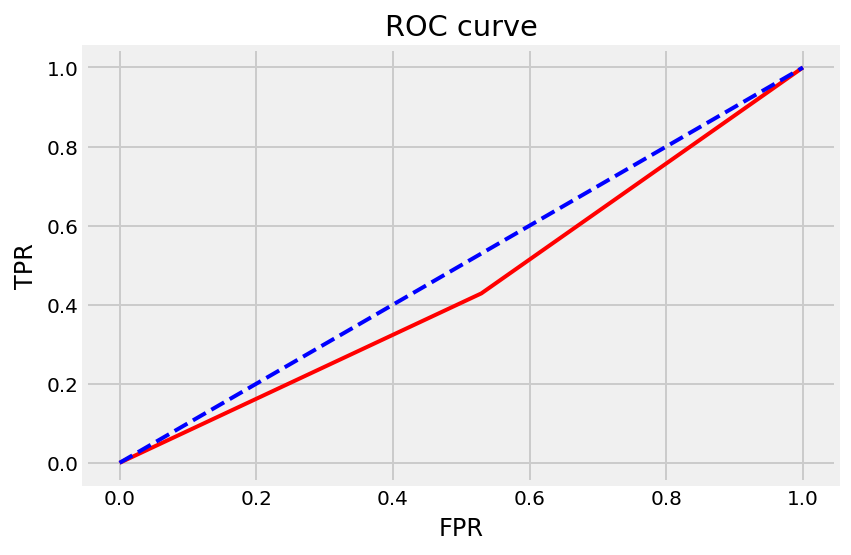

In [185]:
# Plotting the ROC Curve
#Computing false and true positive rates
fpr, tpr,_=roc_curve(y_test,y_train,drop_intermediate=False)

import matplotlib.pyplot as plt
plt.figure()
##Adding the ROC
plt.plot(fpr, tpr, color='red',
 lw=2, label='ROC curve')
##Random FPR and TPR
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
##Title and label
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

In [219]:
# Using Decision Trees

from sklearn.tree import DecisionTreeClassifier as dtree



In [276]:
dt_ = dtree().fit(X_train_ss, y_train)

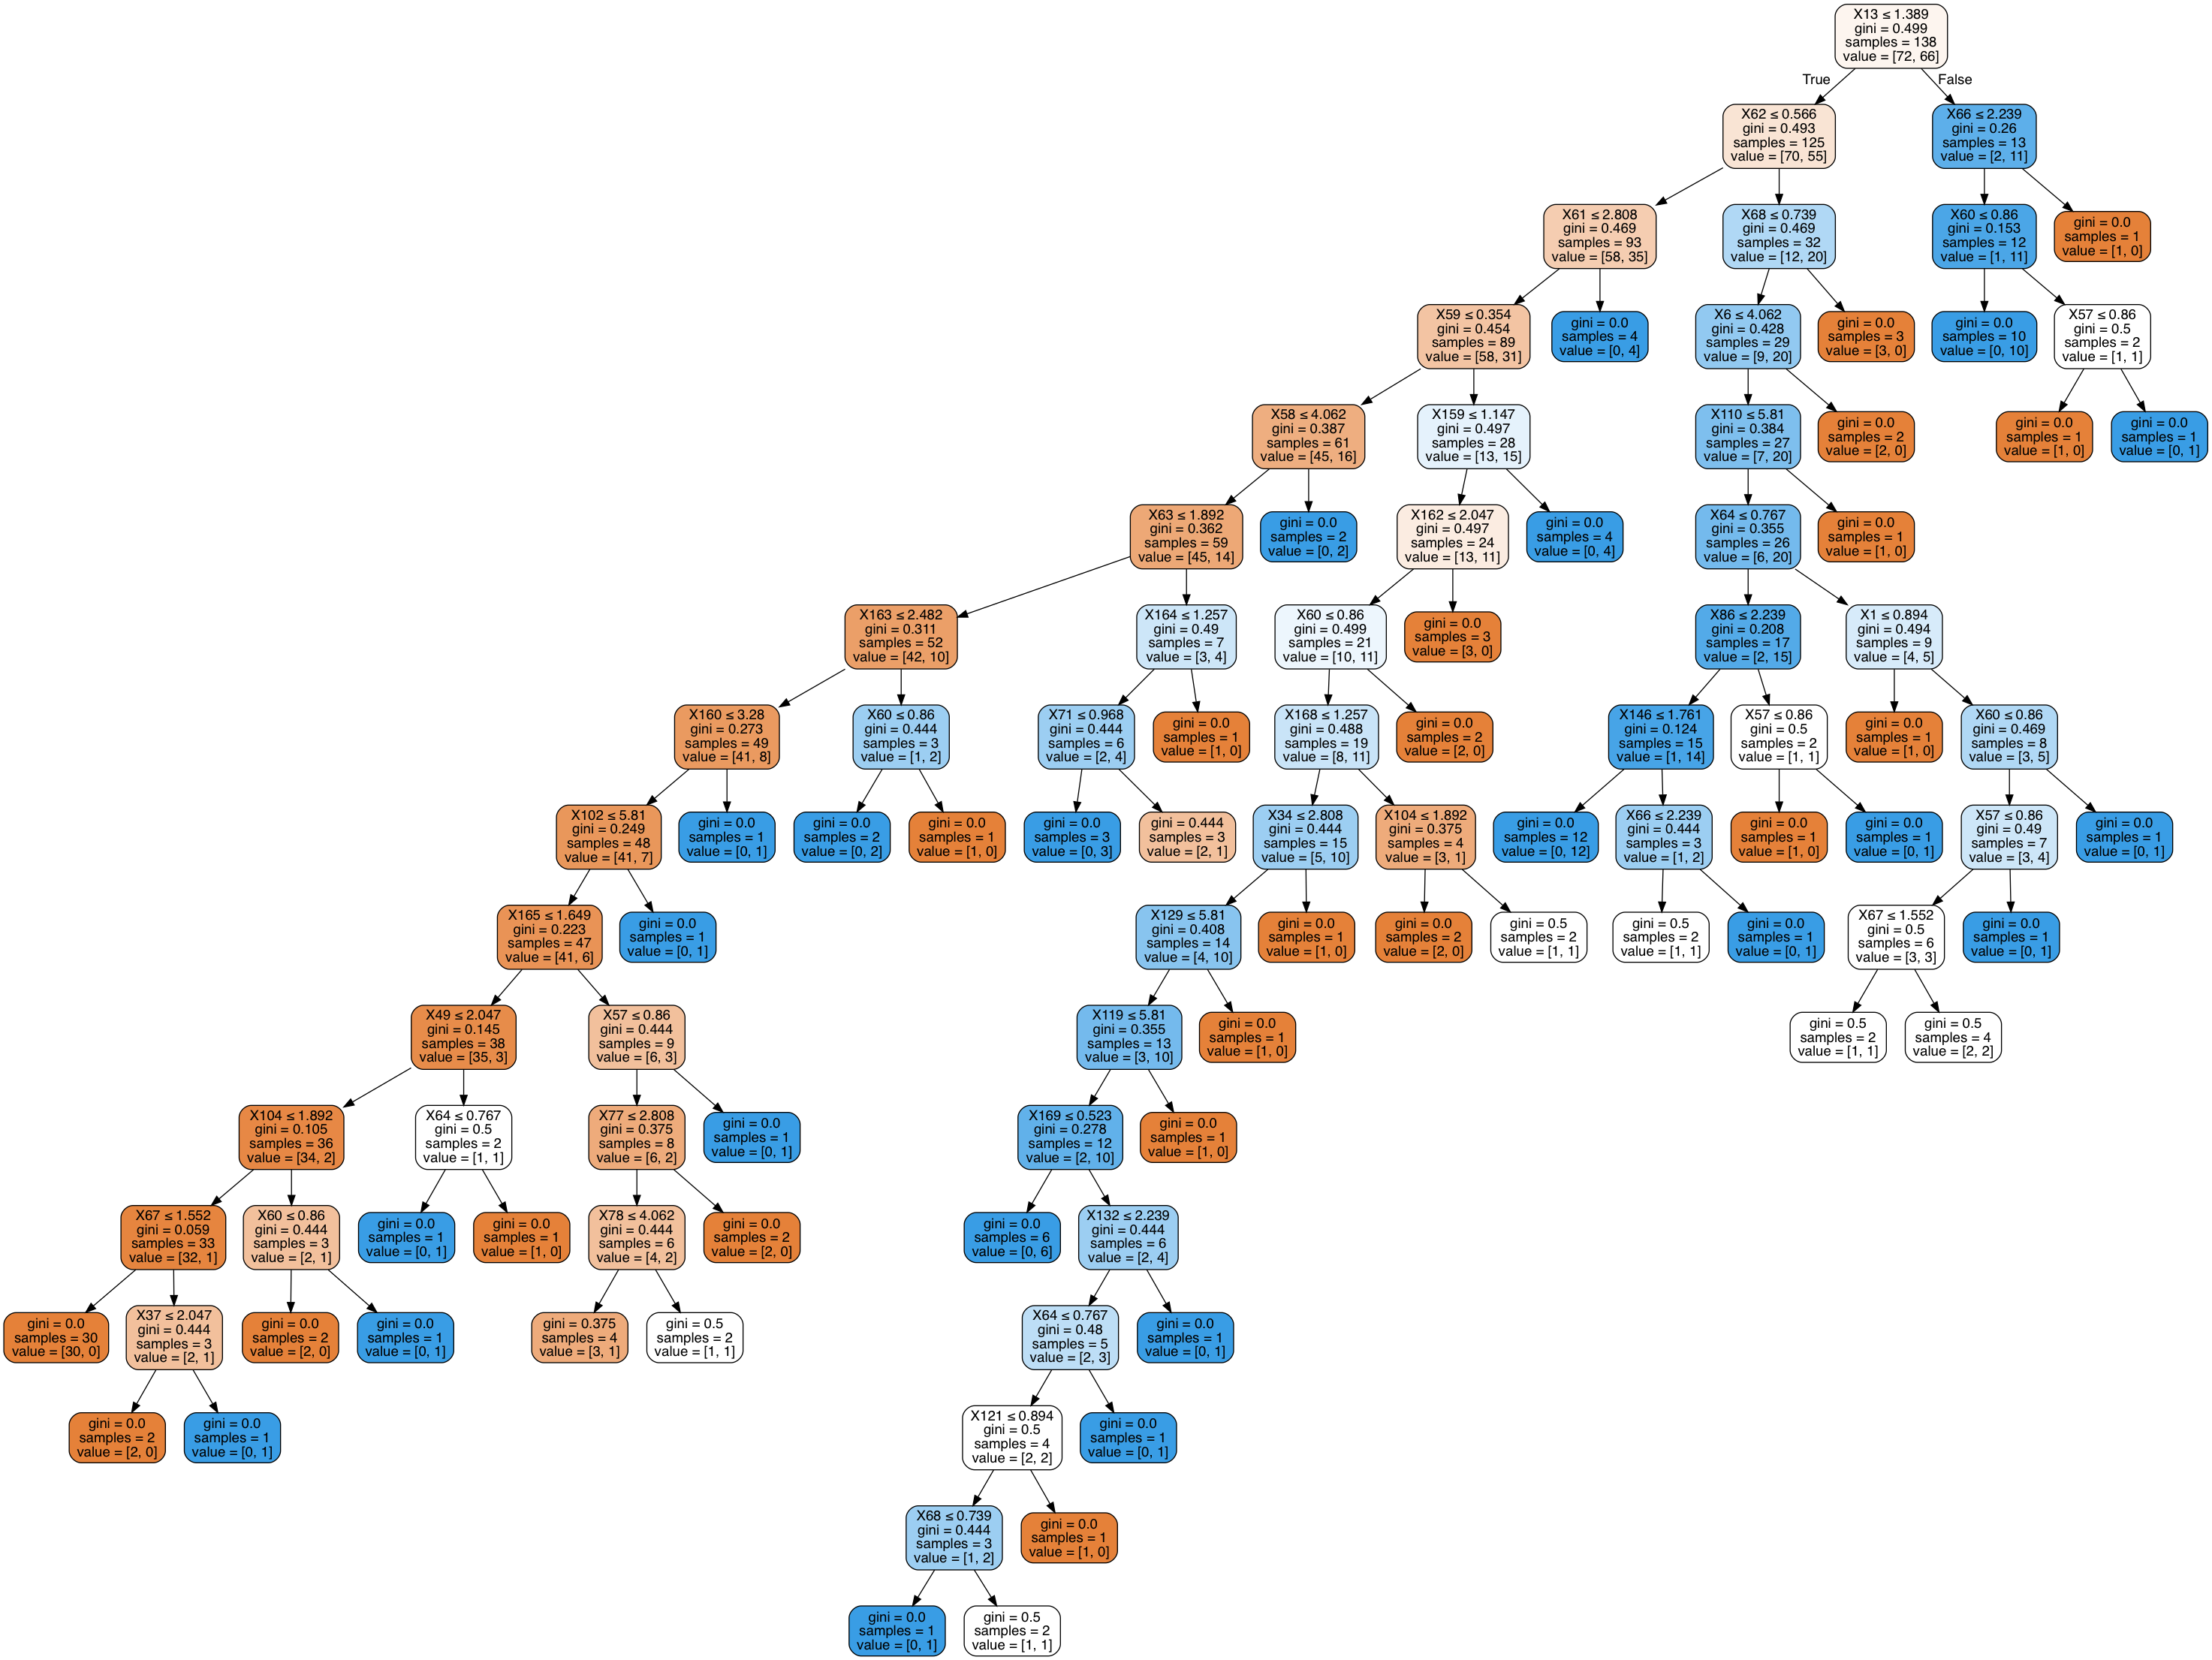

In [277]:
# Plotting the decision tree

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()  

export_graphviz(dt_, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)  

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [274]:
DT_params = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}
DT_gridsearch = GridSearchCV(dtree(), tree_para, cv=5)
DT_gridsearch.fit(X_train_ss, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30, 40, 50, 70, 90, 120, 150]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [275]:
DT_gridsearch.best_params_

{'criterion': 'entropy', 'max_depth': 9}

In [282]:
# I am now going to repeat the Decision Tree with the parameters that I found in my gridsearch:

dt_ = dtree(criterion='entropy', max_depth=9).fit(X_train_ss, y_train)

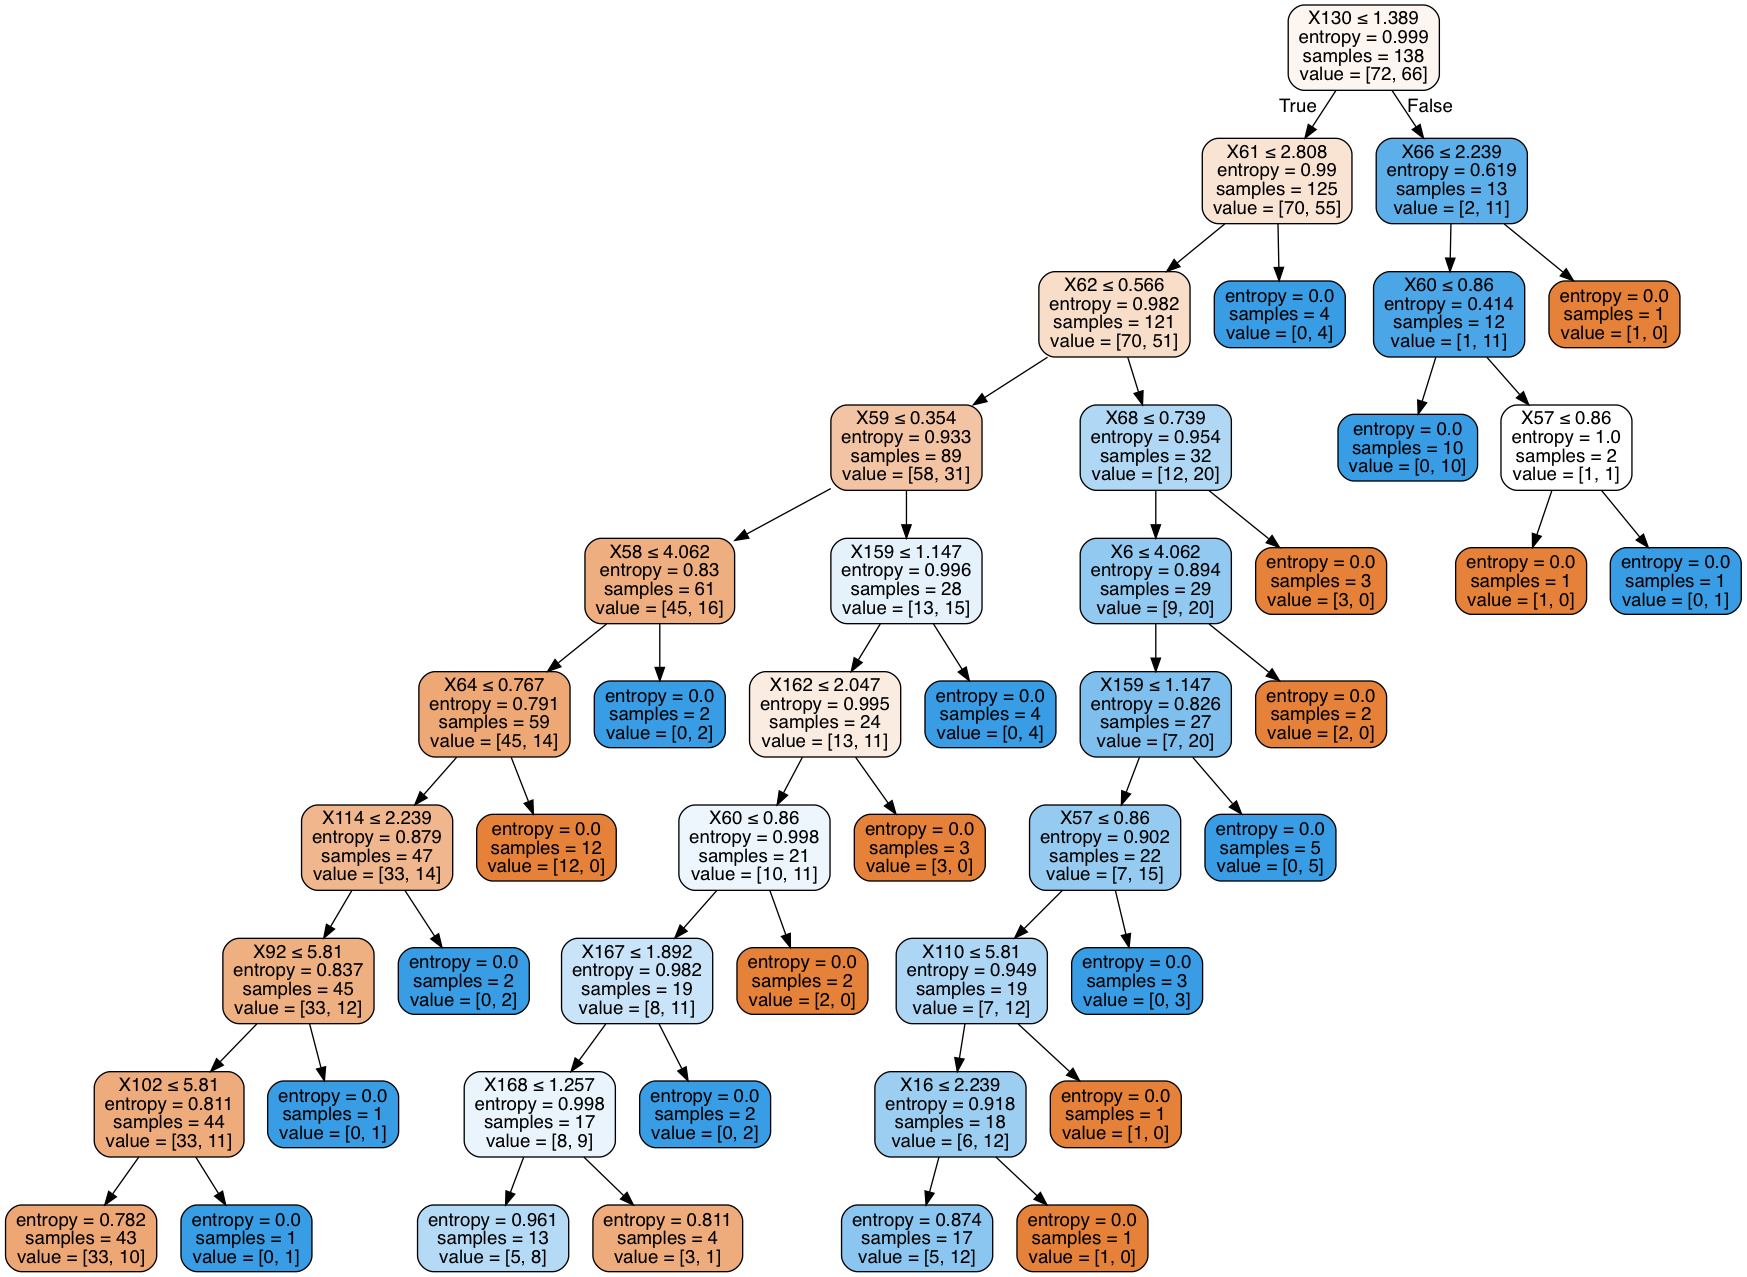

In [283]:
# And now plot it once more as it should look much better with the gridsearched parameters

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()  

export_graphviz(dt_, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)  

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [237]:
RF_params = {'max_features':np.arange(1,12),'max_depth':np.arange(2,50,5), 'n_estimators':(np.arange(2,50,5))}
RF_gridsearch = GridSearchCV(RandomForestClassifier(),
                             RF_params,
                             n_jobs=-1, cv=None, verbose=1)
RF_gridsearch

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_features': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]), 'max_depth': array([ 2,  7, 12, 17, 22, 27, 32, 37, 42, 47]), 'n_estimators': array([ 2,  7, 12, 17, 22, 27, 32, 37, 42, 47])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [270]:
# AdaBoost

from sklearn.ensemble import AdaBoostClassifier as adaboost

ada = adaboost().fit(X_train, y_train)


In [217]:
ada.score(X_train, y_train)

0.84057971014492749

In [229]:
RF_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 1100 candidates, totalling 5500 fits


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 1480 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 3480 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 5080 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 5500 out of 5500 | elapsed:  1.9min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_features': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]), 'max_depth': array([ 2,  7, 12, 17, 22, 27, 32, 37, 42, 47]), 'n_estimators': array([ 2,  7, 12, 17, 22, 27, 32, 37, 42, 47])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [235]:
# Inserting in the classifier the best parameters obtained with the gridsearch

from sklearn.ensemble import RandomForestClassifier

RFC = RandomForestClassifier(max_depth=2, max_features=11, n_estimators=42).fit(X_train, y_train)



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features=11, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=42, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [228]:
from sklearn.model_selection import GridSearchCV
RF_params = {'max_features':np.arange(1,12),'max_depth':np.arange(2,50,5), 'n_estimators':(np.arange(2,50,5))}
RF_gridsearch = GridSearchCV(RandomForestClassifier(),
                             RF_params,
                             n_jobs=-1, cv=5, verbose=1)
RF_gridsearch

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_features': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]), 'max_depth': array([ 2,  7, 12, 17, 22, 27, 32, 37, 42, 47]), 'n_estimators': array([ 2,  7, 12, 17, 22, 27, 32, 37, 42, 47])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [213]:
RFC.score(X_train, y_train)

0.89855072463768115

### Summarize your results in an executive summary written for a non-technical audience.
   
- Writeups should be at least 500-1000 words, defining any technical terms, explaining your approach, as well as any risks and limitations.

The whole point of the Second Part of the project was to determine whether a salary was going to be high or low based on a multitude of features. 
First of all, I had to identify features that could distinguish one data science job from another. I therefore couldn't use the function ".get_dummies". I proceeded in writing a function which would pop up a one or a zero if a certain component of a data scientist's job could be found ('junior','manager','analyst', etc.). I repeated the same thing for the companies (in order to determine for example which companies belonged to the "education" category). This enabled me to use the data in a more proficient manner. 
I then had to perform further cleaning because minor issues were disturbing my analysis. For example, I proceeded in splitting some data on commas, in order to get two different columns of state and city. 
Regarding the modeling that we would use to predict the binary_variable, I chose to use two models. 
First, I used logistic regression because this is a classification issue. I set up the binary variable as a target and all the features as predictors. I got a score of .76 and set up a confusion matrix and an ROC Curve.
I then used the decision tree classifier and plotted it. I proceeded in imporoving the hyperparameters with gridsearching. I also fitted an AdaBoost classifier. 
I found it important to gridsearch parameters for both the decision tree and the RandomForestClassifier. The advantages of gridsearching can be seen on the DecisionTree which now is much clearer. 
I finished with a RandomForestClassifier and got a score of .89. 


### BONUS

Convert your executive summary into a public blog post of at least 500 words, in which you document your approach in a tutorial for other aspiring data scientists. Link to this in your notebook.

In [ ]:
## YOUR LINK HERE IN MARKDOWN FORMAT 